# Seminario de Ciencia de Datos - Trabajo práctico 2
### de la Fuente, Alethia- Hesse, Eugenia -  Baglivo, Fabricio

#### Configuraciones generales

In [1]:
import networkx as nx
from scipy.io import loadmat
from scipy.signal import welch
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 
import pandas as pd
import seaborn as sns
from scipy import stats
import os
import csv
import random

#path de los archivos
#file_path = 'C:\\Users\\Amelie\\Documents\\Cursos\\CienciadeDatos\\TP4_Redes\\' 
file_path = 'F:\\Cursos Doctorado\\CienciaDeDatos\\4.RedesComplejas\\'
file_name = 'data.csv'

## 1. Creación del Grafo
####  A partir del archivo de datos, genere el grafo de colaboraciones entre autores. Cuente el número de nodos y aristas. 

In [2]:
#creación del grafo
authors_indx = 3 # número de columna en la que están los autores
split_char = '&' # caracter que separa a los autores
coauthorships = [] #lista de tuples de coautorías

with open(file_path + file_name, newline = '') as f:
    reader = csv.reader(f)
    for row in reader:      
        authors = list(map(str.strip, row[authors_indx].split(split_char)))

        if len(authors) > 1: #solo se incluyen aquellos autores que comparten autoría (NO ÚNICOS AUTORES)          
            #para cada par de autores adjunto a la lista de tuples
            for a1 in range(0,len(authors)-1):
                for a2 in range(a1 + 1,len(authors)):
                    coauthorships.append((authors[a1],authors[a2]))


In [3]:
#inicialización del grafo
grafo = nx.Graph()
#agrego las aristas del grafo como vértices 
grafo.add_edges_from(coauthorships)
#matriz de adyacencia
adj_matrix = nx.to_numpy_matrix(grafo)

# Número de nodos
nr_nodos = np.array(grafo.nodes())
print('Número de nodos = ' + str(nr_nodos.shape[0]) + '.')

# Número de aristas
nr_aristas = len(grafo.edges())
print('Número de aristas = ' + str(nr_aristas) + '.')

# Número de componentes conexas
nr_componentes_conexas = nx.number_connected_components(grafo)
print('Número de componentes conexas = ' + str(nr_componentes_conexas) + '.')

Número de nodos = 3698.
Número de aristas = 7865.
Número de componentes conexas = 236.


### Haga una representación gráfica del grafo.

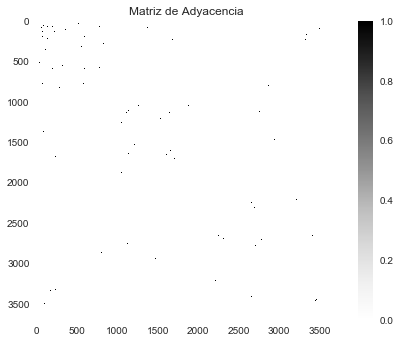

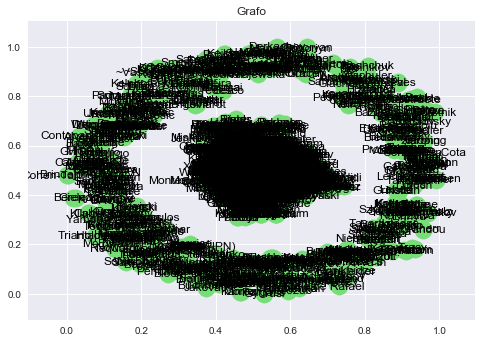

In [11]:
#plot de la matriz de adyacencia
plt.imshow(adj_matrix);
plt.colorbar()
plt.title('Matriz de Adyacencia')
plt.show()  

#plot del grafo
plt.figure()
GREEN = "#77DD77"
nx.draw_networkx(grafo, node_color=GREEN, with_labels=True)
plt.title('Grafo')
plt.show()

## 2. Distribución de Grado

#### Grafique la distribución de grado de los autores, en escalas lineales, semilogarítmica, y log-log. Argumente, a partir de los gráficos, de qué tipo de distribución se trata.

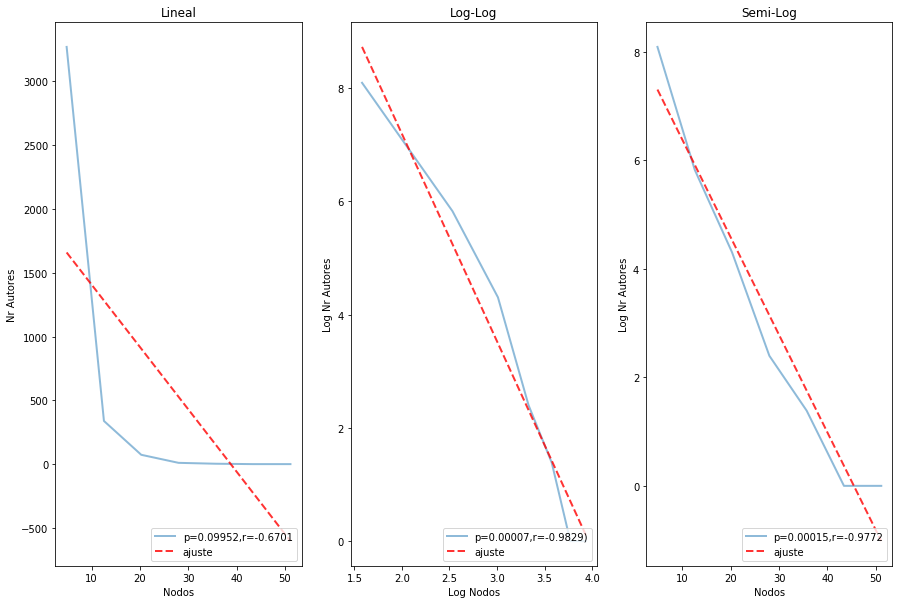

In [127]:
#obtengo los grados de los autores
#grados = pd.DataFrame(list(grafo.degree().values()))
grados = list(dict(grafo.degree()).values())

#calculo de la distribución a través de un histograma de autores por grado
cuentas,rangos = np.histogram(grados,bins=7)
centros = (rangos[:-1] + rangos[1:]) / 2

#datos transformados
log_cuentas = np.log(cuentas).copy()
log_centros = np.log(centros).copy()

#plot de resultados
plot_dim1 = 1
plot_dim2 = 3

fig, axarr = plt.subplots(plot_dim1,plot_dim2, sharey=True) 
fig.set_size_inches(15, 10)

# grados sin transformar / lineales
plt.subplot(plot_dim1,plot_dim2,1)

[r,pval] = stats.pearsonr(centros,cuentas)  
plt.plot(centros,cuentas , lw=2, alpha=0.5,
                 label='p=%0.5f,r=%0.4f' % (pval,r))

m, b = np.polyfit(centros,cuentas, 1)
plt.plot(centros, m*centros + b, linestyle='--', lw=2, color='r',
                label='ajuste', alpha=.8) 

plt.xlabel('Nodos')
plt.ylabel('Nr Autores')
plt.title('Lineal')
plt.legend(loc="lower right")

#log-log de grados 
plt.subplot(plot_dim1,plot_dim2,2)
[ll_r,ll_pval] = stats.pearsonr(log_centros,log_cuentas)  
plt.plot(log_centros ,log_cuentas , lw=2, alpha=0.5,
             label='p=%0.5f,r=%0.4f)' % (ll_pval,ll_r))  

ll_m, ll_b = np.polyfit(log_centros,log_cuentas, 1)
plt.plot(log_centros, ll_m*log_centros + ll_b, linestyle='--', lw=2, color='r',
            label='ajuste', alpha=.8)  

plt.xlabel('Log Nodos')
plt.ylabel('Log Nr Autores')
plt.title('Log-Log') 
plt.legend(loc="lower right")

#semi-log de grados 
plt.subplot(plot_dim1,plot_dim2,3)
[sl_r,sl_pval] = stats.pearsonr(centros,log_cuentas)  
plt.plot(centros ,log_cuentas , lw=2, alpha=0.5,
             label='p=%0.5f,r=%0.4f' % (sl_pval,sl_r))

sl_m, sl_b = np.polyfit(centros,log_cuentas, 1)
plt.plot(centros, sl_m*centros + sl_b, linestyle='--', lw=2, color='r',
            label='ajuste', alpha=.8) 
plt.xlabel('Nodos')
plt.ylabel('Log Nr Autores')
plt.title('Semi-Log') 
plt.legend(loc="lower right")
plt.show()

Conclusión: Los datos ajustan mejor a una distribución libre de escala o de ley de potencias ya que el mejor ajuste pertence a la escala Log-Log. 

## 3. Componentes Conexas
#### Calcule el número de componentes conexas del grafo. Muestre el tamaño de la componente mayor, o componente gigante.

In [5]:
#obtengo el número de componentes conexas
num_comp_con = nx.number_connected_components(grafo)
print('Número de componentes conexas = ' + str(num_comp_con))

#settings del plot
LAYOUTS = {
    'circular': nx.circular_layout,
    'fr': nx.fruchterman_reingold_layout,
    'random': nx.random_layout,
    'shell': nx.shell_layout,
    'spectral': nx.spectral_layout,
    'spring': nx.spring_layout
}
pos=LAYOUTS['circular'](grafo) 
    
#identificar el componente mayor
Gcc = sorted(nx.connected_component_subgraphs(grafo), key = len, reverse=True)
G0 = Gcc[0]

Número de componentes conexas = 236


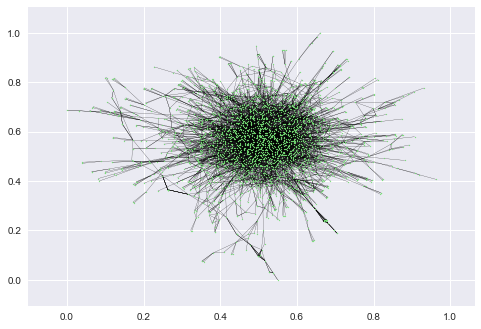

In [55]:
#MUESTRE EL TAMAÑO DE LA COMPONENTE MAYOR

nx.draw_networkx(G0, node_color=GREEN, with_labels=False,width=0.20, node_size=1)
plt.title('Componente Mayor')
plt.show()

## 4. Tamaños de Vecindades
#### Trabajando con la componente gigante del grafo, estudie, parándose en un nodo al azar, como aumenta el número de autores alcanzados a medida que se aleja del nodo semilla. Grafique el número de autores alcanzados en función de la distancia al nodo semilla. Grafique también el número de nuevos autores que se agregan en cada paso, y estime el máximo de esta función. Pruebe con varios nodos semillas y analice la robustez de este resultado. Discuta el significado de los gráficos y su relación con el fenómeno de seis grados de separación.

In [17]:
#definición de funciones para el cálculo de vecindades

#Por cada autor en la lista node_list busca sus vecinos del grafo graph, y agrega aquellos no estaban
# en la lista de los autores ya conocidos, known_list.
def get_neighbors(node_list,known_list,graph):
    #INPUTS:
    #node_list : lista de los nodos sobre los que se buscarán los vecinos
    #known_list: lista de los nodos ya conocidos
    #graph: grafo a utilizar
    #OUTPUTS:
    #known_list: se devuelve la lista ingresada de nodos conocidos aquellos recorridos en el llamado a la función
    #new_neighs: lista de los nodos nuevos que fueron agregados
    new_neighs = []
    for n in node_list:        
        neighs = nx.neighbors(graph,n)
        d = list(np.setdiff1d(neighs,known_list))
        #known_list.append(d)
        known_list = known_list + d
        #new_neighs.append(d)
        new_neighs = new_neighs + d
        
    return known_list,new_neighs

#Para un nodo de un grafo se calcula la distancia de los nodos recorridos al nodo semilla
# y se grafica la cantidad total de nodos recorridos vs la distancia al nodo semilla, 
# y la cantidad de nuevos nodos por cada paso de distancia.
def plot_neighbors_from_seed(seed,graph):
    #INPUTS:
    #seed: índice del nodo que se debe utilizar
    #graph: grafo a utilizar
    #OUTPUTS:
    #max_x: la distancia en la que el máximo de nuevos autores fueron agregados

    starting_node = [graph.nodes()[seed]]
    num_k = [] #list que tiene el nro de autores alcanzados
    delta_k = [] #list de la cantidad de autores que se agregan
    known_list = starting_node
    actual_nodes = starting_node
    prev_n = 0

    while (prev_n < len(known_list)):
        prev_n = len(known_list)
        known_list, actual_nodes = get_neighbors(actual_nodes,known_list,graph)
        num_k.append(len(known_list))
        delta_k.append(len(actual_nodes))
    
    #plot
    max_x = plot_neighbors(starting_node,num_k,delta_k)
    return max_x
    
# Grafica la cantidad total de nodos recorridos vs la distancia al nodo semilla, 
# y la cantidad de nuevos nodos por cada paso de distancia.
def plot_neighbors(title,num_k,delta_k):
    #INPUTS:
    #title: titulo del gráfico
    #num_k: lista con la cantidad de nodos recorridos
    #delta_k: lista con la cantidad de nuevos nodos agregados por cada paso de distancia
    #OUTPUTS:
    #max_x: la distancia en la que el máximo de nuevos autores fueron agregados
    #plot 
    f, axarr = plt.subplots(1,2)
    x = np.arange(1, len(num_k)+1)
    axarr[0].plot(x,num_k)
    f.suptitle(title, fontsize=14)
    axarr[0].set_xlabel('Distancia al nodo semilla')
    axarr[0].set_ylabel('Nr de autores alcanzados')

    x = np.arange(1, len(delta_k)+1)
    axarr[1].plot(x, delta_k)
    axarr[1].set_xlabel('Distancia al nodo semilla')
    axarr[1].set_ylabel('Nr de nuevos autores')
    max_y = max(delta_k)
    max_x = x[delta_k.index(max_y)]
    axarr[1].set_title('Max: x = ' + str(max_x) + ', y = ' + str(max_y))
    plt.show()
    
    return max_x

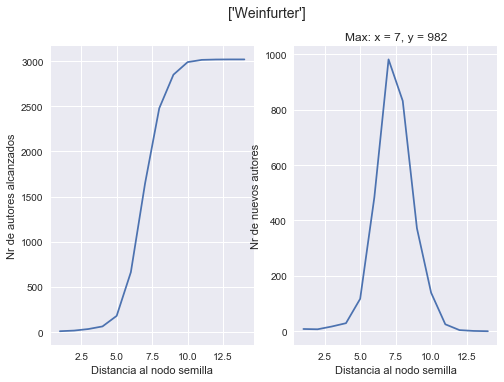

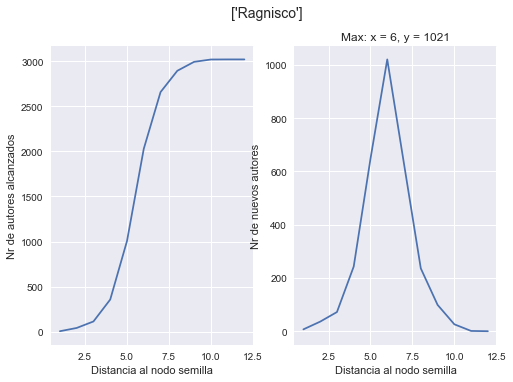

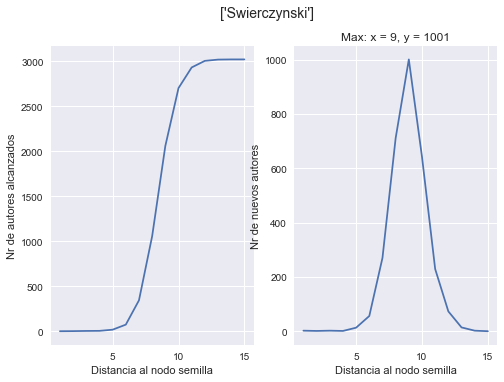

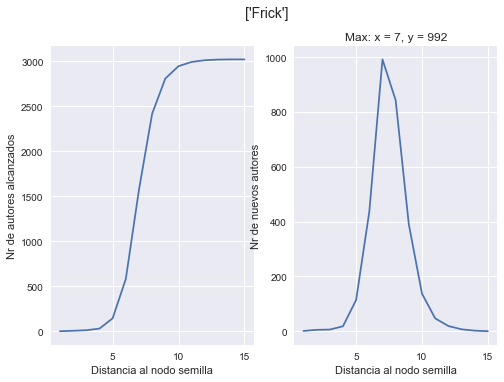

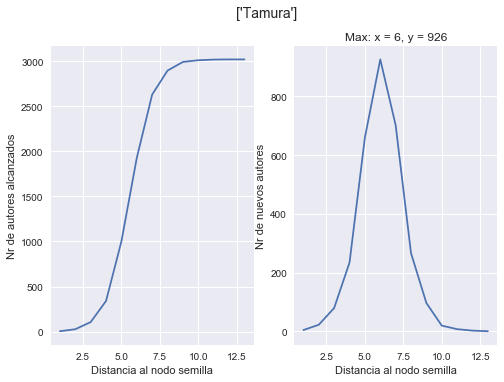

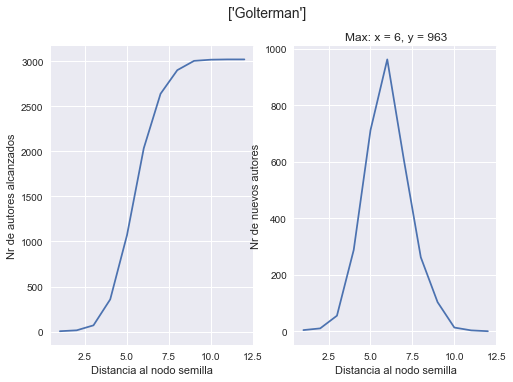

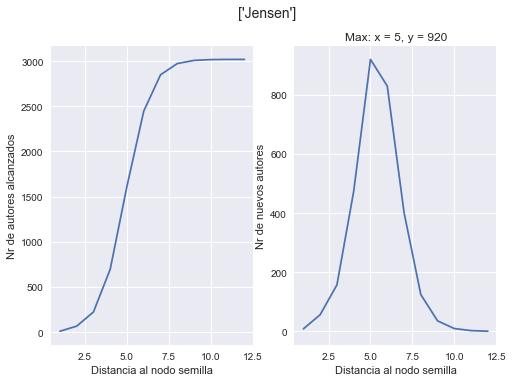

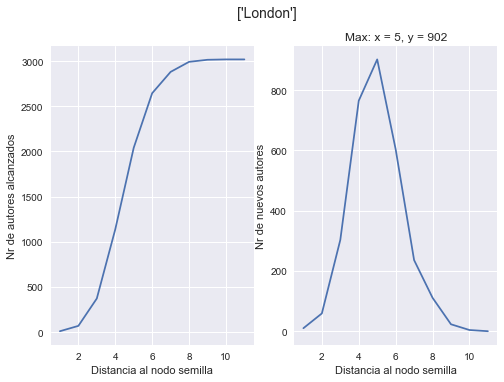

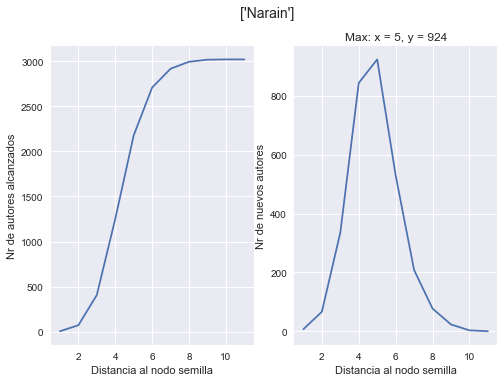

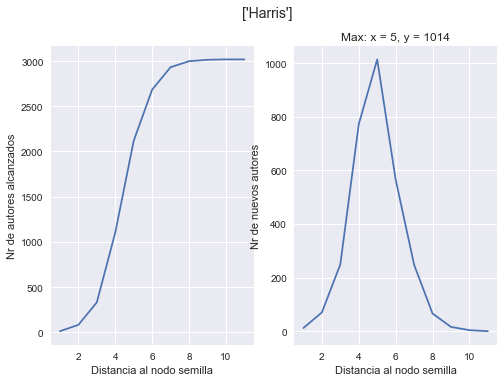

6.1


In [18]:
nr_vueltas = 10 #cantidad de 'trials' de vecinos a calcular
max_xs = np.zeros((nr_vueltas,1))
for i in range(0,nr_vueltas):
    seed = random.randint(0, len(G0.nodes())) #asigno un valor random de nodo
    max_x = plot_neighbors_from_seed(seed,G0)
    max_xs[i] = max_x

mean_x = np.mean(max_xs)
print(mean_x)

Conclusión: El promedio de la distancia en la que se agrega el mayor número de autores nuevos es de 6. Este valor es un punto de inflexión a partir del cuál rápidamente se alcanza toda la red. Estos resultados reflejan el fenómeno de 6 grados de separación.

## 5. Mundos Pequeños
#### Compute el coeficiente de clustering C y el camino mínimo medio l para la componente gigante. Genere un grafo aleatorio con la misma distribución de grado y compute las mismas medidas para este grafo. Compare e interprete los resultados. ¿Se trata de un grafo con estructura de mundos pequeños?

In [48]:
# Analisis de coeficiente de clustering C para coautores:
coaut_CC = nx.average_clustering(G0)
print(['Coautores: Coeficiente de Clustering promedio (C) = ' + str(round(coaut_CC,3))])

# Analisis de camino mınimo medio L para coautores:
coaut_L = nx.average_shortest_path_length(G0)
print(['Coautores: Camino Mínimo Medio (L) = ' + str(round(coaut_L,3))])         

## Generacion del grafo aleatorio con igual n y p que el de coautorias
r_G = nx.random_degree_sequence_graph(degree_dist, seed=None, tries=10)
#degree_dist = G0.degree().values() 
degree_dist = list()
[degree_dist.append(node[1]) for node in list(G0.degree())]

if nx.is_connected(r_G):
    r_CC = nx.average_clustering(r_G)
    print(['Grafo Aleatorio: Coeficiente de Clustering promedio = ' + str(round(r_CC,3))])
    r_L = nx.average_shortest_path_length(r_G)
    print(['Grafo Aleatorio: Camino Mínimo Medio (Lr): ' + str(round(r_L,3))])
    sigma = (coaut_CC/r_CC)/(coaut_L/r_L)
    print('Coeficiente de Small World = ' + str(sigma))
    
else:
    r_CC = nx.average_clustering(r_G)
    print(['Grafo Aleatorio: Coeficiente de Clustering promedio = ' + str(round(r_CC,3))])
    #Grafo inconexo, me quedo con el componente mayor
    r_Gcc = sorted(nx.connected_component_subgraphs(r_G), key = len, reverse=True)
    r_G0 = r_Gcc[0]
    r_L = nx.average_shortest_path_length(r_G0)
    print(['Grafo Aleatorio: Camino Mínimo Medio (Lr): ' + str(round(r_L,3))])
    
    print('Proporcion de nodos : ' + str(len(r_G0.nodes())/len(G0.nodes())))
    print('Proporcion de aristas : ' + str(len(r_G0.edges())/len(G0.edges())))
    sigma = (coaut_CC/r_CC)/(coaut_L/r_L)
    print('Coeficiente de Small World = ' + str(sigma))

['Coautores: Coeficiente de Clustering promedio (C) = 0.484']
['Coautores: Camino Mínimo Medio (L) = 6.131']
['Grafo Aleatorio: Coeficiente de Clustering promedio = 0.003']
['Grafo Aleatorio: Camino Mínimo Medio (Lr): 4.737']
Proporcion de nodos : 0.9953611663353215
Proporcion de aristas : 1.0008270158511372
Coeficiente de Small World = 111.64337037907792


Conclusión: Al generar un grafo aleatorio con la distribución de grados, se generó un grafo no conexo. Para poder avanzar, decidimos tomar el mayor componente del grafo aleatorio y comparar el número de nodos y aristas con el grafo de coautorias (el componente mayor). Como ambas proporciones son cercanas a 1, decidimos continuar así. En cuanto al Clustering, el grafo aleatorio presentó un valor mucho menor, y el camino mínimo medio es menor al del componente mayor del grafo de coautorías. Para determinar si el grafo de coautorias tiene una estructura de small world, decidimos calcular el coeficiente de small world (sigma = (Clustering/ClusteringAleatorio)/(Camino Mínimo Medio/Camino Mínimo Medio Aleatorio)). Si este coeficiente es mayor a 1 se trata de un grafo cuya estructura es small world. Como el resultado es mayor que 1, se verifica que el componente mayor del grafo de coautorías presenta una estructura de small world.

## 6. Estrellas
#### Discuta como haría para individuar a los autores “estrella” del campo. Evalúe quiénes son estos autores según por lo menos dos métricas diferentes. Analice qué sucedería con la comunidad si estos autores desapareciesen. En particular, determine cuántos autores deberían desaparecer para que desaparezca la componente gigante del grafo.

In [119]:
# Los autores estrella van a ser 
import operator

# Estrellas por su grado
#print(G0.degree())
#grados = pd.DataFrame(list(G0.degree().values()))degree_dist
#grados = pd.DataFrame(degree_dist)
#grados = grados.sort_values(by=0, ascending=0).copy()
#nodos = np.array([grados.index])
#names = G0.nodes([nodos])
#print(grados)

grados = dict(G0.degree)
sorted_grados = sorted(grados.items(), key=operator.itemgetter(1),reverse=True)
print(sorted_grados[:10])

d_G0 = G0.copy()

d_nr_comp = 1
d_nr_auth = 0
while d_nr_comp == 1 :
    author = sorted_grados[d_nr_auth][0] 
    print(author)
    d_G0.remove_nodes_from(author)
    d_nr_comp = len(list(nx.connected_component_subgraphs(d_G0)))
    d_nr_auth = d_nr_auth + 1
   
    
print('Grado, se removieron ' + str(d_nr_auth) + ' autores para desaparezca el componente gigante.')
print('Quedaron ' + str(d_nr_comp) + ' subgrafos.')

[('Lee', 55), ('Ambjorn', 41), ('Kim', 39), ('Ferrara', 35), ('Park', 35), ('Vafa', 34), ('Strominger', 31), ('Gibbons', 28), ('Odintsov', 28), ('Pope', 27)]
Lee
Ambjorn
Grado, se removieron 2 autores para desaparezca el componente gigante.
Quedaron 3 subgrafos.


In [120]:
# Estrellas por su BC
#betweenness = pd.DataFrame(list(nx.betweenness_centrality(G0).values()))
#betweenness = betweenness.sort_values(by=0, ascending=0).copy()
#nodos = np.array([betweenness.index])
#names = G0.nodes([nodos])
#print(names[:10]) 
#print(bc_G0)

betweenness = dict(nx.betweenness_centrality(G0))
sorted_betweenness = sorted(betweenness.items(), key=operator.itemgetter(1),reverse=True)
#sorted_betweenness = sorted(betweenness.items(), key=betweenness.__getitem__,reverse=True)
print(sorted_betweenness[:10])
#print(sorted(nodes_dict, key=nodes_dict.__getitem__,reverse=True)[:10])
b_G0 = G0.copy()

nr_comp = 1
nr_auth = 0
while nr_comp == 1 :
    author = sorted_betweenness[nr_auth][0] 
    print(author)
    b_G0.remove_nodes_from(author)
    nr_comp = len(list(nx.connected_component_subgraphs(b_G0)))
    nr_auth = nr_auth + 1   
    
print('Betweenness, se removieron ' + str(nr_auth) + ' autores para desaparezca el componente gigante.')
print('Quedaron ' + str(nr_comp) + ' subgrafos.')

[('Lee', 0.07571935581356933), ('Kim', 0.05016985457510988), ('Vafa', 0.048580377291446514), ('Ambjorn', 0.04076908377916773), ('Kogan', 0.03677372180546694), ('Gibbons', 0.033634774000014606), ('Li', 0.03300309514181459), ('Ohta', 0.03289854687052753), ('Ivanov', 0.032163877642005276), ('Johnson', 0.032090871272379216)]
Lee
Kim
Vafa
Ambjorn
Betweenness, se removieron 4 autores para desaparezca el componente gigante.
Quedaron 3 subgrafos.


Conclusión: Para identificar los autores "estrella" usaremos su grado y betweenness centrality, ya que el primero indica con cuántos otros autores ha trabajado, y el último indicaría si tiene un rol de "puente" entre autores de diferentes grupos. 
En el caso de grado, se debieron eliminar 2 autores hasta que desaparezca el grafo. Al eliminar 4 autores con alto valor de betweenness centrality desapareció el grafo gigante. Vale decir, en principio, si bien ambas medidas dan resultados similares, el grado del autor es más determinante.